In [63]:
file_path = r'D:\GithubProject\HeliosPredict\RTP_Data\solar_production.xlsx'  # Change this to your actual file path
df = pd.read_excel(file_path)

df.head()

df['temp_cloud_interaction'] = df['temp_c'] * df['cloud_cover']
df['humidity_wind_interaction'] = df['humidity'] * df['wind_kph']


In [64]:
features = ['uv_index', 'condition', 'cloud_cover', 'temp_c', 'humidity', 'wind_kph']
target = 'power(kw)'

X = df[features]
y = df[target]

num_features = ['uv_index', 'cloud_cover', 'temp_c', 'humidity', 'wind_kph']
cat_features = ['condition']


In [65]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [66]:
nn_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


C:\Users\Sarthak Dhiman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6109 - mae: 0.6206 - val_loss: 0.3966 - val_mae: 0.5035
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4142 - mae: 0.5102 - val_loss: 0.3733 - val_mae: 0.4768
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4008 - mae: 0.4952 - val_loss: 0.3864 - val_mae: 0.4857
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3897 - mae: 0.4896 - val_loss: 0.3715 - val_mae: 0.4966
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3871 - mae: 0.4874 - val_loss: 0.3699 - val_mae: 0.4709
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3890 - mae: 0.4893 - val_loss: 0.3708 - val_mae: 0.4859
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3735 - mae: 0.4757 - val_loss: 0.3754 - val_mae: 0.4867
Epoch 8/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3793 - mae: 0.4819 - val_loss: 0.3927 - val_mae: 0.4786
Epoch 9/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss:

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Neural Net -> MAE: 0.4560, RMSE: 0.5888, R²: 0.5110


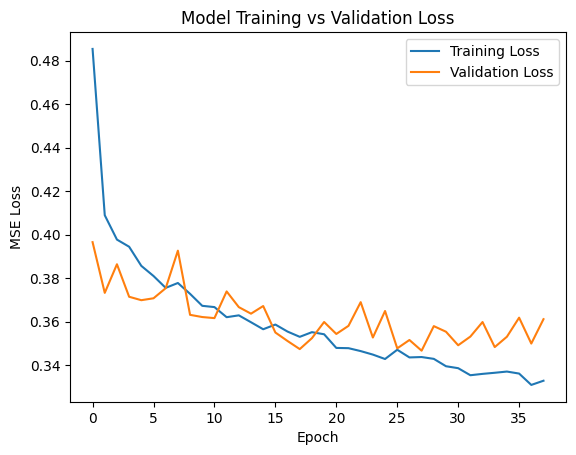

In [67]:
y_pred_nn = nn_model.predict(X_test)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Net -> MAE: {mae_nn:.4f}, RMSE: {rmse_nn:.4f}, R²: {r2_nn:.4f}")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [68]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"RandomForest -> MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}")

RandomForest -> MAE: 0.4195, RMSE: 0.5688, R²: 0.5437


In [69]:
os.makedirs("models", exist_ok=True)
dump(preprocessor, "models/preprocessor.joblib")
nn_model.save("models/nn_model.h5")
dump(rf_model, "models/rf_model.joblib")
print("Models & Preprocessor Saved in /models")

Models & Preprocessor Saved in /models


In [70]:
preprocessor_loaded = load("models/preprocessor.joblib")

nn_loaded = keras.models.load_model("models/nn_model.h5", compile=False)

rf_loaded = load("models/rf_model.joblib")

future_weather = pd.DataFrame([
    {'uv_index': 7, 'condition': 'Sunny', 'cloud_cover': 0, 'temp_c': 30, 'humidity': 40, 'wind_kph': 10}
])

future_weather_processed = preprocessor_loaded.transform(future_weather)

nn_future_pred = nn_loaded.predict(future_weather_processed)[0][0]
rf_future_pred = rf_loaded.predict(future_weather_processed)[0]

print(f"NN Predicted Power: {nn_future_pred:.2f} kW")
print(f"RF Predicted Power: {rf_future_pred:.2f} kW")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
NN Predicted Power: 1.27 kW
RF Predicted Power: 1.34 kW
